# Swire Time Series Modeling

In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
df = pd.read_csv('/Users/kimbuesser/Downloads/IWC_Work_Orders_Extract.csv')

/var/folders/cv/w5d_fnzs4d9730q33hncrkt80000gn/T/ipykernel_54747/4188370338.py:12: DtypeWarning: Columns (8,11,12,13,14,15,16,17,18,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/kimbuesser/Downloads/IWC_Work_Orders_Extract.csv')


### Cleaning

In [3]:
df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = df['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.replace(r' |&|SYSTEMS|G812|TREATMENT|,|-|L(1|2|4|6)|LINES?(1|8|2|3)|2|9|1|410|3|PRD|S$', r'', regex=True)
def label_value(x):
    if x == 'BTL_PET_LINE':
        return 'PETBOTTLELINES'
    else:
        return x

df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = df['FUNCTIONAL_AREA_NODE_2_MODIFIED'].apply(label_value)

In [4]:
df['EXECUTION_START_DATE'] = pd.to_datetime(df['EXECUTION_START_DATE'])
df['Month'] = df['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()

In [60]:
df['Week'] = df['EXECUTION_START_DATE'].dt.to_period('W').dt.to_timestamp()

### Plot to Understand Normal Breakdown Schedule Time
We can see that starting in 2023 the amount of breakdowns skyrocketed compared to the previous 6 years. I want to grab the trends from everything before 2023 to estimate a normal breakdown schedule and use those trends to predict for the future.

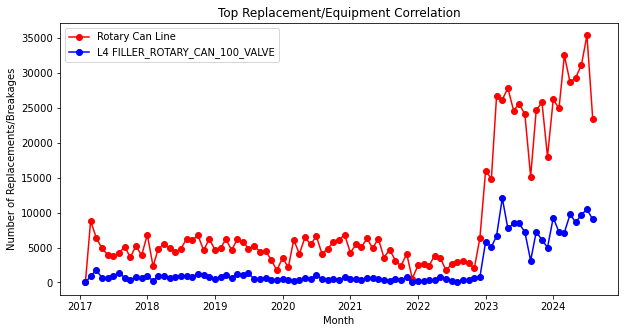

In [5]:
plot_df = df[df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE'].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
plot_df = plot_df.reset_index()
plt.figure(figsize=(10, 5))  # Set the figure size
break_plot_df = df[df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE'].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
break_plot_df = break_plot_df.reset_index()
plt.plot(break_plot_df['Month'], break_plot_df['ACTUAL_WORK_IN_MINUTES'], label='Rotary Can Line', marker='o', linestyle='-', color='r') 
plt.plot(plot_df['Month'], plot_df['ACTUAL_WORK_IN_MINUTES'], label='L4 FILLER_ROTARY_CAN_100_VALVE', marker='o', linestyle='-', color='b')
# Line plot with markers
plt.title('Top Replacement/Equipment Correlation')
plt.xlabel('Month')
plt.ylabel('Number of Replacements/Breakages')
plt.legend()
plt.show()

### Trend before 2023

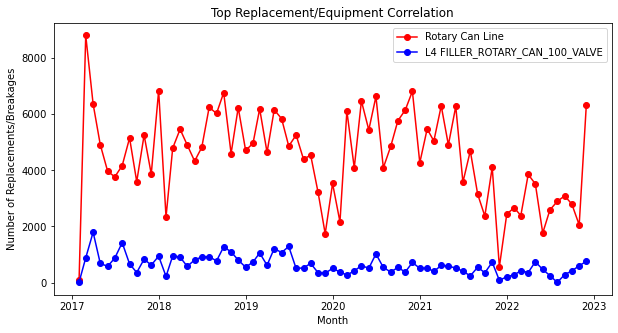

In [8]:
plot_df = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE') & 
    (df['Month'] < '2023-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
plot_df = plot_df.reset_index()

break_plot_df = df[
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE') & 
    (df['Month'] < '2023-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
break_plot_df = break_plot_df.reset_index()

# Plotting
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(break_plot_df['Month'], break_plot_df['ACTUAL_WORK_IN_MINUTES'], label='Rotary Can Line', marker='o', linestyle='-', color='r') 
plt.plot(plot_df['Month'], plot_df['ACTUAL_WORK_IN_MINUTES'], label='L4 FILLER_ROTARY_CAN_100_VALVE', marker='o', linestyle='-', color='b')
plt.title('Top Replacement/Equipment Correlation')
plt.xlabel('Month')
plt.ylabel('Number of Replacements/Breakages')
plt.legend()
plt.show()


# Prophet for Rotary Can Line before 2023 Monthly

14:02:22 - cmdstanpy - INFO - Chain [1] start processing
14:02:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 1894663.3191820267
R-squared: 0.28472669554433006


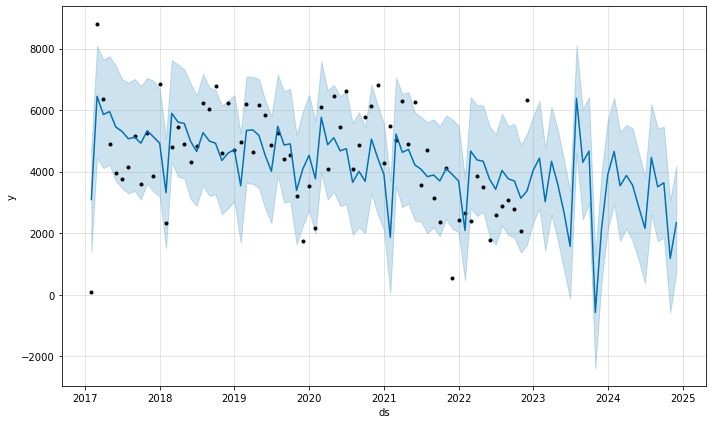

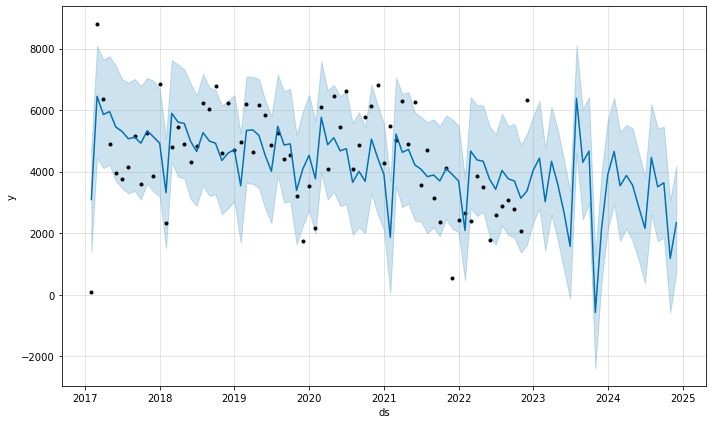

In [13]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

rotary_can_ts = df[
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE') & 
    (df['Month'] < '2023-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
rotary_can_ts = rotary_can_ts.reset_index()

rotary_can_ts['Month'] = pd.to_datetime(rotary_can_ts['Month'])

# Prepare the data for Prophet
prophet_data = rotary_can_ts.rename(columns={'Month': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=24, freq='M')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Month']]
actual = rotary_can_ts.set_index('Month')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)


## Hyperparameter tuning to improve R2

14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 1815706.6792605144
R-squared: 0.314534406589139


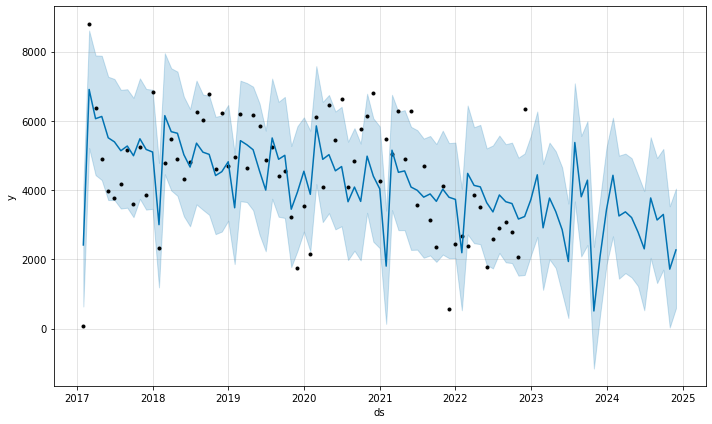

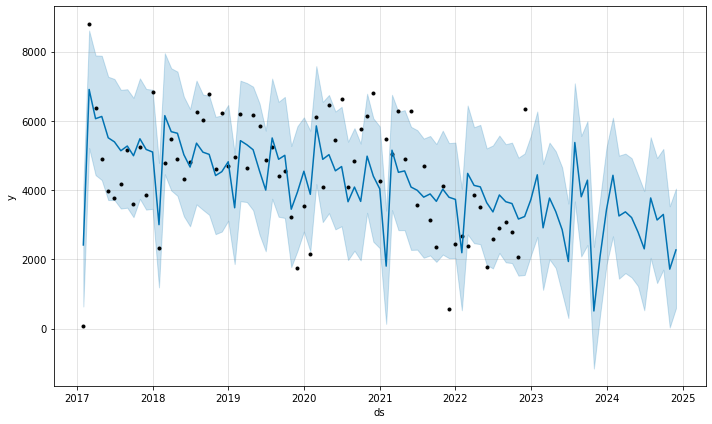

In [38]:
# Prepare the data for Prophet
prophet_data = rotary_can_ts.rename(columns={'Month': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Fit the Prophet model
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
# model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Add monthly seasonality if applicable
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=24, freq='M')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Month']]
actual = rotary_can_ts.set_index('Month')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)

In [14]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-02-01,5698.221096,1389.328015,4762.445034,5698.221096,5698.221096,-2605.130728,-2605.130728,-2605.130728,-2605.130728,-2605.130728,-2605.130728,0.0,0.0,0.0,3093.090368
1,2017-03-01,5674.690340,4449.268933,8082.568807,5674.690340,5674.690340,772.925714,772.925714,772.925714,772.925714,772.925714,772.925714,0.0,0.0,0.0,6447.616054
2,2017-04-01,5648.638431,4114.337076,7637.866345,5648.638431,5648.638431,207.579643,207.579643,207.579643,207.579643,207.579643,207.579643,0.0,0.0,0.0,5856.218075
3,2017-05-01,5623.426907,4225.686871,7753.914086,5623.426907,5623.426907,326.820673,326.820673,326.820673,326.820673,326.820673,326.820673,0.0,0.0,0.0,5950.247580
4,2017-06-01,5597.374998,3694.688411,7430.264814,5597.374998,5597.374998,-150.906895,-150.906895,-150.906895,-150.906895,-150.906895,-150.906895,0.0,0.0,0.0,5446.468103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2024-07-31,3397.617230,2623.780363,6199.299050,3397.596704,3397.639384,1063.912928,1063.912928,1063.912928,1063.912928,1063.912928,1063.912928,0.0,0.0,0.0,4461.530157
91,2024-08-31,3371.555601,1736.153739,5411.468083,3371.533727,3371.579062,134.368146,134.368146,134.368146,134.368146,134.368146,134.368146,0.0,0.0,0.0,3505.923747
92,2024-09-30,3346.334671,1857.802144,5457.364036,3346.311269,3346.359890,293.479068,293.479068,293.479068,293.479068,293.479068,293.479068,0.0,0.0,0.0,3639.813739
93,2024-10-31,3320.273042,-586.040544,3060.519683,3320.248317,3320.300110,-2139.471079,-2139.471079,-2139.471079,-2139.471079,-2139.471079,-2139.471079,0.0,0.0,0.0,1180.801964


# Roma

## Testing Weekly Trend

14:48:54 - cmdstanpy - INFO - Chain [1] start processing
14:48:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 489237.3635666704
R-squared: 0.08120353674110248


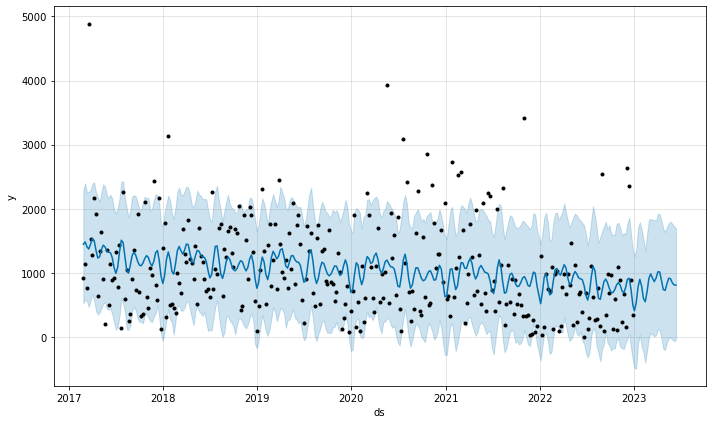

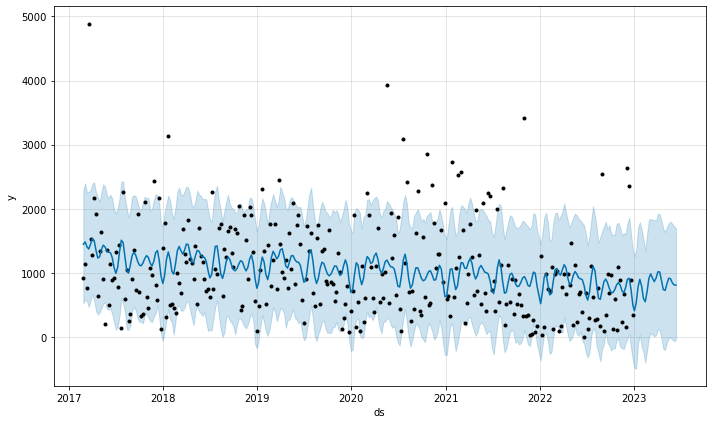

In [61]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

rotary_can_ts = df[
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE') & 
    (df['Week'] < '2023-01-01')
].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
rotary_can_ts = rotary_can_ts.reset_index()

rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

# Prepare the data for Prophet
prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=24, freq='W')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
actual = rotary_can_ts.set_index('Week')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)

# Prophet for L4 FILLER_ROTARY_CAN_100_VALVE before 2023

14:36:12 - cmdstanpy - INFO - Chain [1] start processing
14:36:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 61527.5732820424
R-squared: 0.4343681922073188


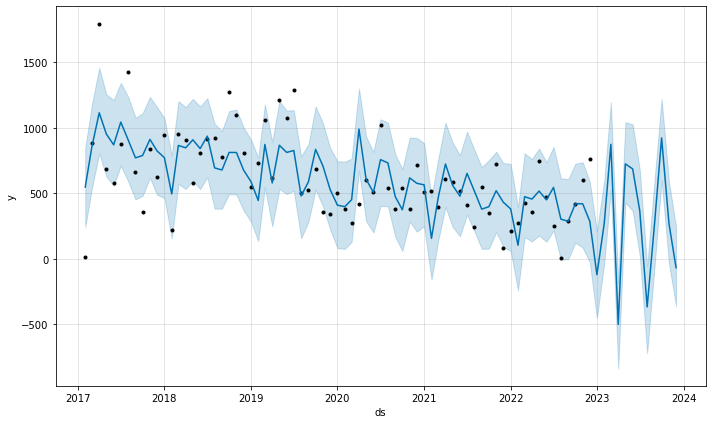

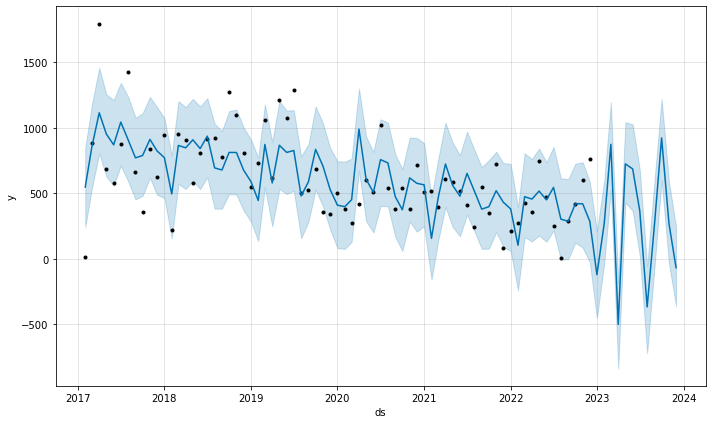

In [49]:
l4_filler = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE') & 
    (df['Month'] < '2023-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
l4_filler = l4_filler.reset_index()

l4_filler['Month'] = pd.to_datetime(l4_filler['Month'])

# Prepare the data for Prophet
prophet_data = l4_filler.rename(columns={'Month': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=12, freq='M')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[l4_filler['Month']]
actual = l4_filler.set_index('Month')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)

## Hyperparameter Tuning

First Model: multiplicative, changepoint_prior = 0.01, monthly, fourier = 5: R2 = .57

14:36:17 - cmdstanpy - INFO - Chain [1] start processing
14:36:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 46408.03002849464
R-squared: 0.5733643223537339


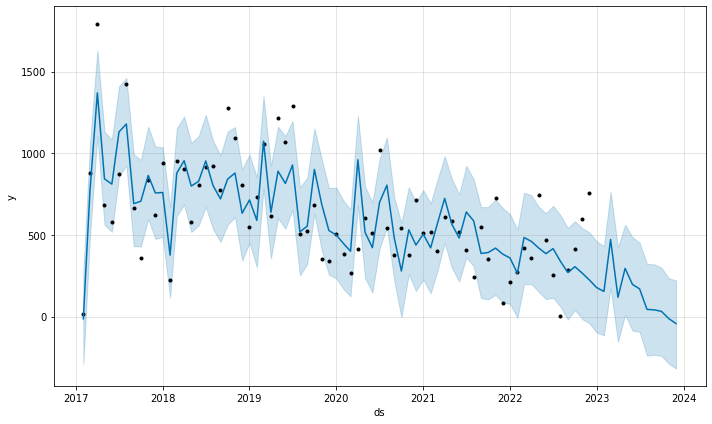

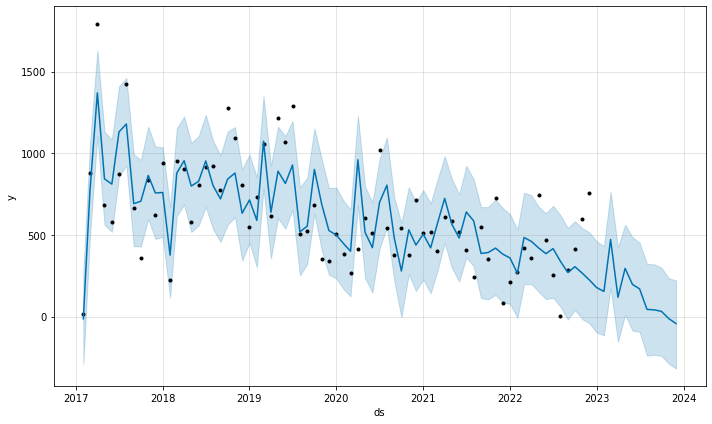

In [50]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

# Adjust Prophet model with smoother trend sensitivity
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.01)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Add monthly seasonality if applicable
model.fit(prophet_data)

# Make predictions
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Evaluate and plot
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[l4_filler['Month']]
actual = l4_filler.set_index('Month')
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

model.plot(forecast)


## Experimenting with using less training Data 2019 - 2023

14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 30891.347617495067
R-squared: 0.5631539543665369


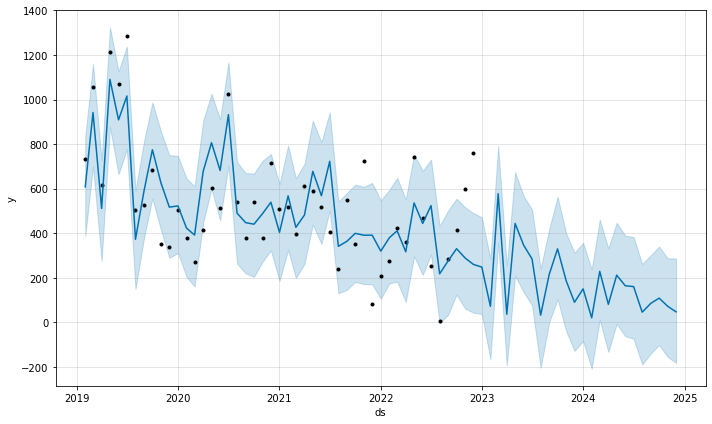

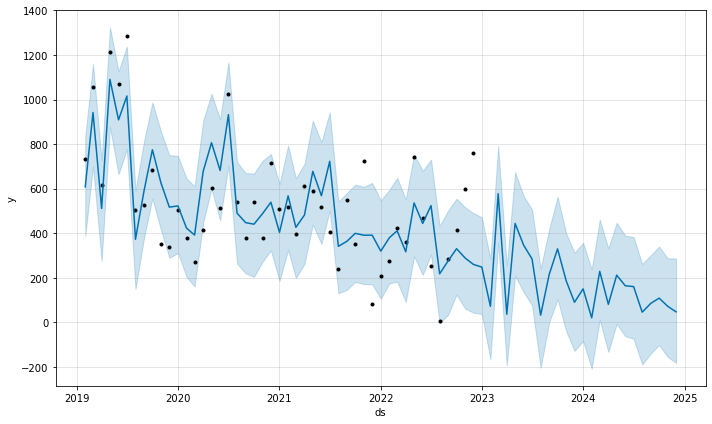

In [59]:
l4_filler = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE') & 
    (df['Month'] < '2023-01-01') &
    (df['Month'] > '2019-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
l4_filler = l4_filler.reset_index()

l4_filler['Month'] = pd.to_datetime(l4_filler['Month'])

# Prepare the data for Prophet
prophet_data = l4_filler.rename(columns={'Month': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Hyperparameter Tuning
changepoints = ['2021-09-01', '2022-09-01']

# Fit the Prophet model
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.1, changepoints=changepoints)
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=24, freq='M')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[l4_filler['Month']]
actual = l4_filler.set_index('Month')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)

## Log Transformation to deal with negative predictions

14:36:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:58 - cmdstanpy - INFO - Chain [1] done processing


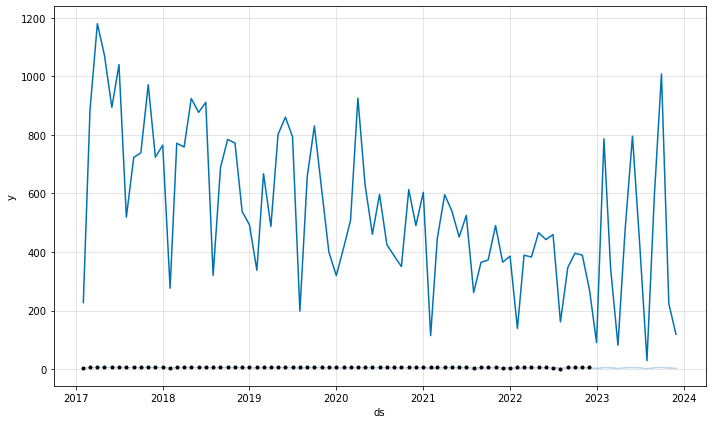

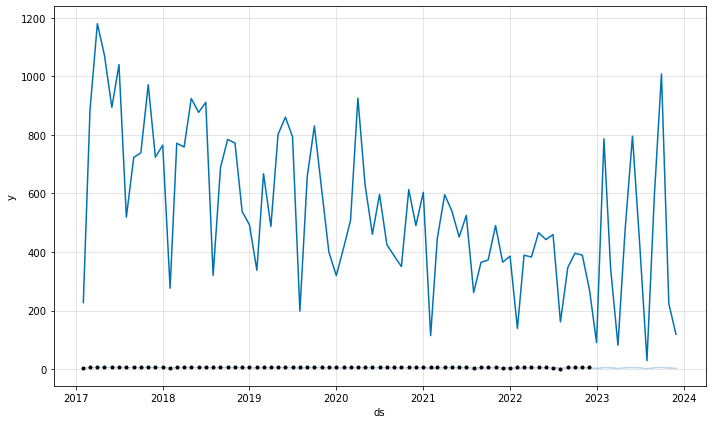

In [52]:
import numpy as np
from prophet import Prophet

# Apply log transformation to avoid negative predictions
prophet_data['y'] = np.log1p(prophet_data['y'])  # log1p to handle zero values

# Train the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make future predictions
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Transform predictions back
forecast['yhat'] = np.expm1(forecast['yhat'])  # expm1 reverses log1p

# Plot the results
model.plot(forecast)


### Experimenting with Changepoints

14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 2600397.917362756
R-squared: 0.7296910724053578


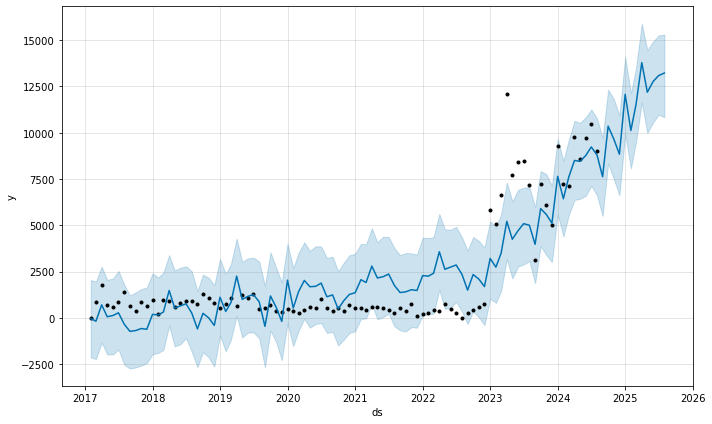

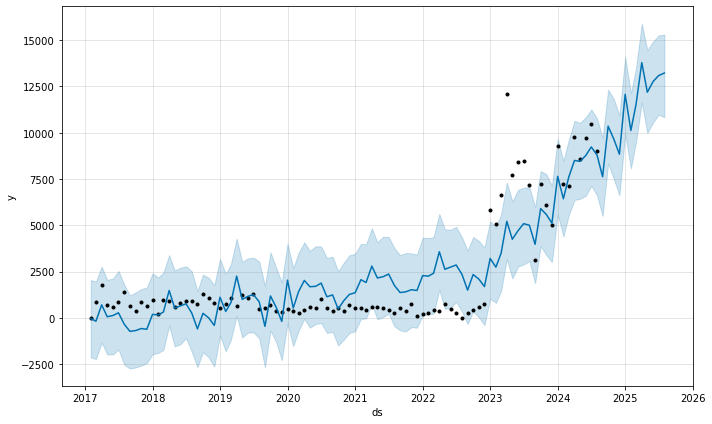

In [47]:
l4_filler = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
l4_filler = l4_filler.reset_index()

l4_filler['Month'] = pd.to_datetime(l4_filler['Month'])

# Prepare the data for Prophet
prophet_data = l4_filler.rename(columns={'Month': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Hyperparameter Tuning
changepoints = ['2023-01-01', '2024-05-01']

# Fit the Prophet model
model = Prophet(changepoints=changepoints, changepoint_prior_scale=0.1)
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=12, freq='M')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[l4_filler['Month']]
actual = l4_filler.set_index('Month')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)